In [32]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as sf
data_path = "datos/sample_10e4.json"

from pyspark.sql.functions import dayofweek, dayofmonth, weekofyear, month, year

import matplotlib.pyplot as plt
import pandas as pd


spark = SparkSession.builder.getOrCreate()
df = spark.read.json(data_path)

### Ideas:
* **Mapear** cuantas salidas y entradas hay en un barrio
* **Posibilidad** estudiarlo como grafo con el groupby de idea3
* **Grafico** L M X J V S D, luego hacer un collect del año entero
* Salidas menos entradas para ver cuantas en uso en barrios, por porcentajes, por barrio.
* **Maxima** cantidad de bici en un momento dado
* **Estudio global:** plot de 12 meses de salidas/ dias y tarta de portentaje de uso global (sumatorio de años) de cada año 
* **Conclusion:** que barrios son los más activos, si ha aumentado el uso
* Anexo de edades

In [33]:
data_geo  = "datos/bases_bicimad.csv"
from pyspark.sql.types import StringType
df_geo    = spark.read.csv(data_geo, header=True)
df_geo    = df_geo.withColumnRenamed('Número', 'plug_station')
df_geo    = df_geo.withColumn('plug_station', sf.col('plug_station').cast(StringType()))
df        = spark.read.json(data_path)
df        = df.withColumn('idplug_station', sf.col('idplug_station').cast(StringType()))
df        = df.withColumn('unplug_hourTime', sf.col('unplug_hourTime').cast(StringType()))
df        = df.withColumn('unplug_hourTime', sf.col('unplug_hourTime').substr(2, 10))

In [284]:
df.limit(5).toPandas()

,_id,ageRange,idplug_base,idplug_station,idunplug_base,idunplug_station,track,travel_time,unplug_hourTime,user_day_code,user_type,zip_code
0,"(59477d642f38430c500d7285,)",4,6,58,2,111,None,390,2017-06-12,f921b9c3fcee0848e18456817e70dd264064669cb7304d...,1,28004
1,"(5b1c52162f3843201c5dee63,)",4,26,90,15,40,"([(Row(coordinates=[-3.68088499972222, 40.4215...",692,2018-06-05,db2ea5a180bddd8486ddabb174fffdd8c774ace726d311...,1,28013
2,"(59e46b0c2f38432040c33521,)",4,24,172,22,136,"([(Row(coordinates=[-3.677193, 40.457155499722...",2055,2017-10-10,2205231ee045b927ff57c58d4ad42f197b89ada6f43d83...,1,28045
3,"(59adcf3b2f38432f98f3685b,)",5,10,109,22,51,"([(Row(coordinates=[-3.68992979972222, 40.4254...",848,2017-08-31,48a8905d6e28ad0f4e4e64cad0b0163e7e932a31725171...,1,28005
4,"(595ccc722f38430f00d48853,)",4,1,101,6,45,"([(Row(coordinates=[-3.6816081, 40.4220885], t...",646,2017-06-28,3848bb88e9c394913370e85948a0ef0d4064e7f7bea177...,1,28004


Vamos a centrar nuestro análisis en los barrios, para ello primero analizaremos un caso concreto

el de **Inserta barrio**

In [26]:
df_barrios = df_geo.select('plug_station', 'Barrio')
df_barrios.printSchema()

root
 |-- plug_station: string (nullable = true)
 |-- Barrio: string (nullable = true)



In [27]:
df_unido_llegadas = df.join(df_barrios, df_barrios.plug_station ==  df.idplug_station,"left")
df_unido_llegadas = df_unido_llegadas.withColumnRenamed('Barrio', 'Barrio_L')

df_unido_salidas  = df.join(df_barrios, df_barrios.plug_station ==  df.idunplug_station,"left")
df_unido_salidas  = df_unido_salidas.withColumnRenamed('Barrio', 'Barrio_S')

In [287]:
df_unido_llegadas.limit(5).toPandas()

,_id,ageRange,idplug_base,idplug_station,idunplug_base,idunplug_station,track,travel_time,unplug_hourTime,user_day_code,user_type,zip_code,plug_station,Barrio_L
0,"(59477d642f38430c500d7285,)",4,6,58,2,111,None,390,2017-06-12,f921b9c3fcee0848e18456817e70dd264064669cb7304d...,1,28004,58,01-04 JUSTICIA
1,"(5b1c52162f3843201c5dee63,)",4,26,90,15,40,"([(Row(coordinates=[-3.68088499972222, 40.4215...",692,2018-06-05,db2ea5a180bddd8486ddabb174fffdd8c774ace726d311...,1,28013,90,04-01 RECOLETOS
2,"(59e46b0c2f38432040c33521,)",4,24,172,22,136,"([(Row(coordinates=[-3.677193, 40.457155499722...",2055,2017-10-10,2205231ee045b927ff57c58d4ad42f197b89ada6f43d83...,1,28045,172,02-06 PALOS DE MOGUER
3,"(59adcf3b2f38432f98f3685b,)",5,10,109,22,51,"([(Row(coordinates=[-3.68992979972222, 40.4254...",848,2017-08-31,48a8905d6e28ad0f4e4e64cad0b0163e7e932a31725171...,1,28005,109,04-06 CASTELLANA
4,"(595ccc722f38430f00d48853,)",4,1,101,6,45,"([(Row(coordinates=[-3.6816081, 40.4220885], t...",646,2017-06-28,3848bb88e9c394913370e85948a0ef0d4064e7f7bea177...,1,28004,101,04-02 GOYA


In [28]:
salidas     = ['idunplug_station', 'unplug_hourTime', 'Barrio_S']
df_salidas  = df_unido_salidas.select(*salidas).groupBy('Barrio_S').count()
df_salidas = df_salidas.withColumnRenamed('count', 'salidas')

llegadas    = ['idplug_station', 'Barrio_L']
df_llegadas = df_unido_llegadas.select(*llegadas).groupBy('Barrio_L').count()
df_llegadas = df_llegadas.withColumnRenamed('count', 'llegadas')

Ahora que tenemos agrupados los datos en una cantidad pequeña , 35, podemos hacer un collect para hacer un plot

In [29]:
df_grafico = df_llegadas.join(df_salidas
                              , df_salidas.Barrio_S ==  df_llegadas.Barrio_L,"left")
df_grafico = df_grafico.select('Barrio_L', 'llegadas', 'salidas')
df_grafico = df_grafico.withColumnRenamed('Barrio_L', 'Barrio')
df_grafico = df_grafico.where(sf.col("Barrio").isNotNull())
df_grafico = df_grafico.orderBy('llegadas')

<Axes: title={'center': 'Visualización de la demanda de las estaciones'}, xlabel='Barrio'>

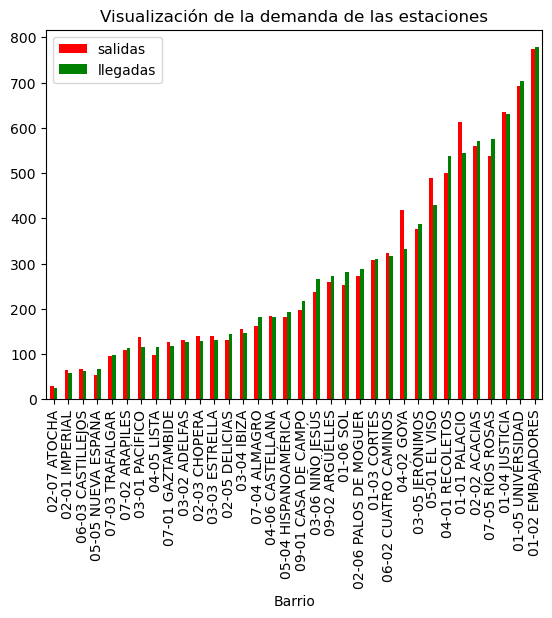

In [290]:
df_grafico.toPandas().plot.bar(
    x='Barrio', 
    y=['salidas','llegadas'], 
    color=['red','green'],
    title="Visualización de la demanda de las estaciones"
)

### Estudio por años

Solo miro las salidas que es la información que tenemos

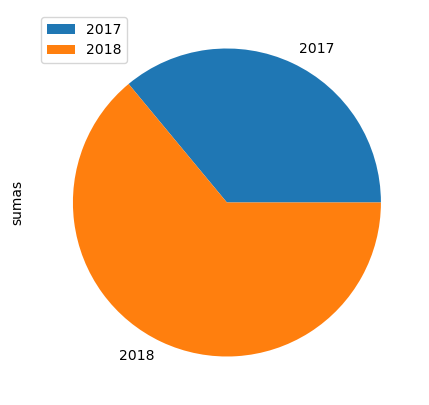

In [30]:
df_year = df.withColumn('unplug_hourTime', sf.col('unplug_hourTime').substr(1, 4))\
            .groupBy('unplug_hourTime')\
            .count()
df_year.limit(5).toPandas()
df_grafico_tarta = pd.DataFrame({'sumas': [3602, 6398]},
                  index=['2017', '2018'])
plot = df_grafico_tarta.plot.pie(y='sumas', figsize=(5, 5))

* Aumento significativo! podemos hacer una comparacion local en barrios

### Pico máximo de uso

In [31]:
df_pico = df_unido_salidas.select(*salidas)\
                        .where(sf.col("Barrio").isNotNull())\
                        .groupBy('Barrio_S')\
                        .count()\
                        .agg({'count': 'max'})

df_pico.show()
# aqui pasa algo, esto no puede ser, es muy alto, mirar df_unido_salidas

+----------+
|max(count)|
+----------+
|       774|
+----------+



####  Obs:Hay que poner tambien lo de un barrio en los 7 dias pero hay que tener cuidado de agrupar correctamente los dias de la semana! 

# Ideas (De aqui en adelante no he tocado nada)

Fila 1 | True
Fila 2 | False

--> df.filter(sf.col('esta_vacio') == True).groupBy('estacion').count()

In [16]:
import pyspark.sql.functions as sf
from pyspark.sql.functions import dayofweek, dayofmonth, weekofyear, month, year

In [17]:
df_1 = df.groupBy('idunplug_station', ).count()
df_1.limit(5).toPandas()

,idunplug_station,count
0,26,73
1,29,21
2,65,73
3,54,51
4,19,75


In [18]:
def preprocess_dates(df):
    df2 = df.withColumn("dayofweek", dayofweek(df.unplug_hourTime.getItem("$date")))\
            .withColumn("weekofyear", weekofyear(df.unplug_hourTime.getItem("$date")))\
            .withColumn("year", year(df.unplug_hourTime.getItem("$date")))\
            .drop('unplug_hourTime')
    return df2

def map_barrio(x):
    plug = get_barrio(x.idunplug_station)
    unplug = get_barrio(x.idunplug_station)
    return Row(ageRange=x.ageRange, idunplug_barrio=unplug, idplug_barrio=plug)
# cambiamos un poco la función get barrio ya que se ha podido modificar a lo largo del tiempo, 
# si nos da un error seguramente es que se halla añadido un a nueva base en la zona, por lo que 
# la llamaremos como "{numero} a"
codes = geo.set_index("Número")["Barrio"].to_dict()
def get_barrio(e):
    try:
        c = codes[e]
    except:
        new_e = str(e) + " a"
        c = codes[new_e]
    finally:
        return c


NameError: name 'geo' is not defined

In [282]:
df = preprocess_dates(df)
df.limit(1).toPandas()

AnalysisException: [INVALID_EXTRACT_BASE_FIELD_TYPE] Can't extract a value from "unplug_hourTime". Need a complex type [STRUCT, ARRAY, MAP] but got "STRING".

In [14]:
import pandas as pd
!pip install xlrd

In [50]:
geo = pd.read_excel('datos/bases_bicimad.xls')
geo.head()
# Barrio 

,Número,Gis_X,Gis_Y,Fecha de Alta,Distrito,Barrio,Calle,Nº Finca,Tipo de Reserva,Número de Plazas,Longitud,Latitud,Direccion
0,001 a,440443.61,4474290.65,43803,01 CENTRO,01-06 SOL,"ALCALA, CALLE, DE",2,BiciMAD,30,-3.701998,40.417111,"ALCALA, CALLE, DE, 2"
1,001 b,440480.56,4474301.74,43867,01 CENTRO,01-06 SOL,"ALCALA, CALLE, DE",6,BiciMAD,30,-3.701564,40.417213,"ALCALA, CALLE, DE, 6"
2,2,440134.83,4474678.23,41813,01 CENTRO,01-05 UNIVERSIDAD,"MIGUEL MOYA, CALLE, DE",1,BiciMAD,24,-3.705674,40.420580,"MIGUEL MOYA, CALLE, DE, 1"
3,3,440012.98,4475760.68,41813,07 CHAMBERÍ,07-02 ARAPILES,"CONDE DEL VALLE DE SUCHIL, PLAZA, DEL",2,BiciMAD,18,-3.707212,40.430322,"CONDE DEL VALLE DE SUCHIL, PLAZA, DEL, 2"
4,4,440396.40,4475565.36,41813,01 CENTRO,01-05 UNIVERSIDAD,"MANUELA MALASAÑA, CALLE, DE",3,BiciMAD,24,-3.702674,40.428590,"MANUELA MALASAÑA, CALLE, DE, 3"


In [51]:
# Cambiar id_unplug por barrio
# Cambiar id_plug   por barrio
# Quitamos las otras

23/05/25 21:40:22 ERROR Executor: Exception in task 0.0 in stage 32.0 (TID 25)
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/david/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 830, in main
    process()
  File "/home/david/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 822, in process
    serializer.dump_stream(out_iter, outfile)
  File "/home/david/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/home/david/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 81, in wrapper
    return f(*args, **kwargs)
  File "/tmp/ipykernel_13310/2574444665.py", line 11, in map_barrio
NameError: name 'Row' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handl

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 32.0 failed 1 times, most recent failure: Lost task 0.0 in stage 32.0 (TID 25) (192.168.231.206 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/david/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 830, in main
    process()
  File "/home/david/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 822, in process
    serializer.dump_stream(out_iter, outfile)
  File "/home/david/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/home/david/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 81, in wrapper
    return f(*args, **kwargs)
  File "/tmp/ipykernel_13310/2574444665.py", line 11, in map_barrio
NameError: name 'Row' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:561)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:767)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:749)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:514)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1019)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2303)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:971)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2284)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2303)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2328)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1019)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1018)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/david/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 830, in main
    process()
  File "/home/david/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 822, in process
    serializer.dump_stream(out_iter, outfile)
  File "/home/david/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/home/david/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 81, in wrapper
    return f(*args, **kwargs)
  File "/tmp/ipykernel_13310/2574444665.py", line 11, in map_barrio
NameError: name 'Row' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:561)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:767)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:749)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:514)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1019)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2303)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


df_rdd.limit(4).toPandas()